## Labeling the fund price

整體想法:
1. 建立n天漲跌幅的資料
2. 計算把n天漲跌幅的資料的標準差 (直接代既有的std公式 from 博宇)
3. 畫圖觀察 (特別注意金融風暴期間的異同)
4. 以n天漲跌幅的分布為標準去做label
* 目前先以n=10天做為基準去操作

### Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def monthStandardDeviation(Data, year):
    '''Calculate month standard deviation of one year'''
    monthStr = ["/01", "/02", "/03", "/04", "/05", "/06", "/07", "/08", "/09", "/10", "/11", "/12"]
    monthDataFrame = pd.DataFrame(columns = ["Date", "Std"])
    
    for i in range (12):
        monthPrice = []
        
        for j in range (Data["Date"].size):
            if (str(str(year) + monthStr[i]) in Data["Date"][j]): # Find the price included in year_month
                monthPrice.append(Data.iloc[:,1][j])
            
        monthStd = np.std(np.array(monthPrice)) # 每月中股價的波動度
        monthDataFrame.loc[i] = [str(str(year) + monthStr[i]), monthStd]
    return monthDataFrame

def yearStdDeviation(Data, start, end):
    '''Get the std dataframe between start year and end year'''
    stdBarDict = {}
    monthStr = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

    for i in range(end - start + 1):
        stdBarDict[str(start + i)] = np.array(monthStandardDeviation(Data, start + i)["Std"])

    yearDataFrame = pd.DataFrame(data = stdBarDict, index = monthStr);
    return yearDataFrame

In [3]:
def ndaysChange(data : pd.DataFrame, n:int) -> pd.DataFrame: 
    """ The input dataframe should consist of 2 columns: date and the one related to price.
        Calculate the %change of each day with n days later and return a dataframe. """
    ndays_change = []
    length = len(data)
    for i in range( length-10 ):
        ndays_change.append(100*(data['Price'].iloc[i+10] - data['Price'].iloc[i])/data['Price'].iloc[i]) #displayed in %
    date = data['Date'][0:length-10]
    price = data['Price'][0:length-10]
    #print(date)
    ndays_dataframe = pd.concat([date, price,pd.Series(ndays_change)],axis=1)
    ndays_dataframe.columns = ['Date','Price', '%change']
    return ndays_dataframe

def ndaysStd(Data:pd.DataFrame, n:int, start_year:int, end_year:int) -> pd.DataFrame:
    """ Calculate the std dataframe with year in column and month in row.
        Using n days %change data from ndaysChange(). """
    ndaysChange_data = ndaysChange(Data,n)
    ndaysStd_data = yearStdDeviation(ndaysChange_data,start_year,end_year)
    return ndaysStd_data

In [4]:
def month_mean_dis(Data, year_list, ndays):
    new_data = ndaysChange(Data,ndays)
    length = new_data.shape[0]
    monthPrice = {}
    monthStr = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    monthDis = {}
    
    for i in range(12):
        monthPrice[monthStr[i]] = []
    #print(monthPrice)
    
    for i in range(length):
        month = new_data['Date'][i][5:7]
        year = new_data['Date'][i][0:4]
        if year in year_list:
            monthPrice[month].append(new_data['%change'][i])
    
    distribution = pd.DataFrame(columns = [".1",".25",".5",".75",".9"], index = monthStr)
    monthPriceArray = np.array(monthPrice['01'])

    for i in range(12):
        month = monthStr[i]
        distribution.loc[month] = np.percentile(np.array(monthPrice[month]),q=[10,25,50,75,90])
        
    return distribution

In [5]:
def labeling(Data, N_day, year_list):
    Data_label = ndaysChange(Data, N_day) #columns : Date,Price,%change
    Data_label['Label'] = ""
    benchmark = month_mean_dis(Data,year_list,N_day)
    for i in range( Data_label.shape[0]):
        month = Data_label['Date'][i][5:7]
        month_dis = benchmark.loc[month]

        change = Data_label['%change'][i]

        if change <= month_dis['.1']:
            Data_label.loc[i,'Label'] = "Extremely High Point"

        elif month_dis['.1'] < change <= month_dis['.25']:
            Data_label.loc[i,'Label'] = "High Point"

        elif month_dis['.25'] < change <= month_dis['.5']:
            Data_label.loc[i,'Label'] = "Little High Point"

        elif month_dis['.5'] < change <= month_dis['.75']:
            Data_label.loc[i,'Label'] = "Little Low Point"

        elif month_dis['.75'] < change <= month_dis['.9']:
            Data_label.loc[i,'Label'] = "Low Point"

        else:
            Data_label.loc[i,'Label'] = "Extremely Low Point"
    Data_label = Data_label.round({'%change':2})
    return Data_label

### Data exploring

In [6]:
Data = pd.read_csv("Nomura_Global_Equity_Fund.csv", usecols = ['Date', 'Price'])

In [7]:
Data.head()

,Date,Price
0,1997/01/04,12.14
1,1997/01/06,12.13
2,1997/01/07,12.12
3,1997/01/08,12.17
4,1997/01/09,12.20


In [8]:
std_10d = ndaysStd(Data,10, 1997,2019)

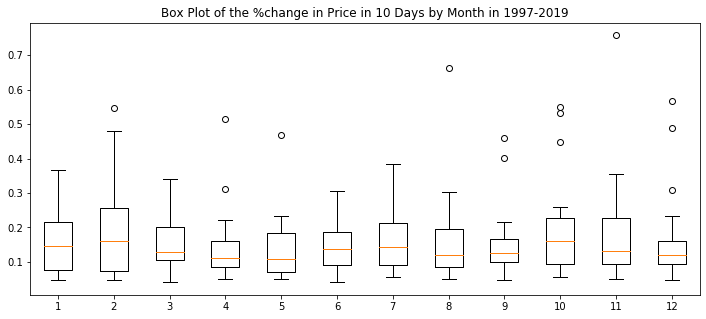

In [9]:
# The box plot of each month in 1997-2019
plt.figure(figsize = [12,5])
plt.title("Box Plot of the %change in Price in 10 Days by Month in 1997-2019")
plt.boxplot(std_10d, labels = range(1,13))
plt.show()
plt.close()

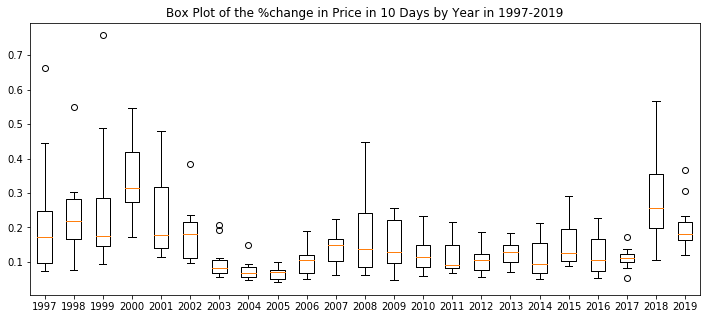

In [10]:
# The box plot of each year in 1997-2019
plt.figure(figsize = [12,5])
plt.title("Box Plot of the %change in Price in 10 Days by Year in 1997-2019")
plt.boxplot(std_10d.T, labels = std_10d.columns)
plt.show()
plt.close()

#### Discovery:

用月份來看，雖各月分中有些許差異，但整體來說不會過於迥異，但觀察年份可以發現，多數在有金融風暴事件發生時，它的波動度範圍是較廣的，ex:1997亞洲金融風暴、2000網路泡沫、2008金融危機，另外較特殊的是2018年雖無特定事件，但仍顯現與金融風暴事件發生時段相似的波動度分布。因此，以下將**分區段**觀察波動度範圍，以決定要以哪些年份的資料作為標記label的標準。

In [ ]:
std_10d_97t00 = ndaysStd(Data,10, 1997,2000)
std_10d_01t07 = ndaysStd(Data,10, 2001,2007)
std_10d_08t09 = ndaysStd(Data,10, 2008,2009)
std_10d_10t19 = ndaysStd(Data,10, 2010,2019)

In [ ]:
def boxplot( data:pd.DataFrame, day:int, start_year:int, end_year:int):
    plt.figure(figsize = [8,4])
    plt.title("%change in Price in "+str(day)+" days by Month in "+str(start_year)+"-"+str(end_year))
    plt.boxplot(data, labels = range(1,13))
    plt.show()
    plt.close()

In [ ]:
boxplot(std_10d_01t07, 10, 2001, 2007)
boxplot(std_10d_10t19, 10, 2010, 2019)
boxplot(std_10d_97t00, 10, 1997, 2000)
boxplot(std_10d_08t09, 10, 2008, 2009)

#### Discovery:

由上可以發現，前兩張圖不涵蓋金融危機的區間較不會出現迥異的差距，但後兩張圖卻有很明顯的波動，因此是否要涵蓋金融危機區間我認為是個重要的因素，應會影響結果的準確性。

### Decision:

目前我先用1997-2019年的10天漲跌幅作為labeling的標準，若之後討論需要修改可以再小修即可。  
可以改善的地方 : 建立標準時採用的年份、遇到金融海嘯大跌大漲的處理、建立標準時所採用的百分位數

In [ ]:
N_day = 10
selected_year = []
for i in range(1997,2020):
    selected_year.append(str(i))

In [ ]:
Data_label = labeling(Data,N_day=10, year_list= selected_year)
Data_label

In [ ]:
Data_label['Label'].value_counts()

In [ ]:
Data_label.to_csv("Labeled_Nomura_Global_Equity_Fund.csv", index = False)